In [36]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import xgboost
warnings.filterwarnings('ignore')
np.random.seed(32)
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import make_column_selector
from sklearn.feature_selection import SelectKBest, f_regression, VarianceThreshold, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, precision_recall_curve, auc, f1_score, confusion_matrix, make_scorer, recall_score, precision_score, ConfusionMatrixDisplay, accuracy_score, fbeta_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC


**Warning!**

The code runs for like 20 minutes. Start all cells at the beginning or you'll have to wait for them to run later on.

In [37]:
with open("train.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

In [38]:
with open("test.pkl", "rb") as f:
    X_test, y_test = pickle.load(f)

In [39]:
X_train.head()
len(X_train)

49000

DO WYRZUCENIA

In [40]:
# Custom SmokingImputer (Returns 2D output)
class SmokingImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.distribution_with_never = None
        self.distribution_without_never = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X, columns=['smoking_history'])
        self.distribution_without_never = X_df.loc[~X_df['smoking_history'].isin(['No Info', 'never']), 'smoking_history'].value_counts(normalize=True)
        self.distribution_with_never = X_df.loc[~X_df['smoking_history'].isin(['No Info']), 'smoking_history'].value_counts(normalize=True)
        return self

    def transform(self, X):
        X_df = pd.DataFrame(X, columns=['smoking_history'])
        mask = X_df['smoking_history'] == 'No Info'
        X_df.loc[mask, 'smoking_history'] = np.random.choice(
            self.distribution_without_never.index, 
            size=mask.sum(), 
            p=self.distribution_without_never.values
        )
        return X_df[['smoking_history']].to_numpy()
    
    def get_feature_names_out(self, input_features=None):
        return input_features if input_features is not None else ['smoking_history']

This function splits text fragments from the clinical notes column. From exploratory data analysis (EDA), we identified 26 unique fragments. We assume that the hospital or clinic using our model will have a predefined choice list containing these 26 possible inputs. To convert this categorical data into numerical format, we apply one-hot encoding, creating separate binary columns for each fragment.

In [41]:
class ClinicalNotesBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
    
    def fit(self, X, y=None):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        X_cleaned = [x for x in X_cleaned if x]
        self.mlb.fit(X_cleaned)
        return self
    
    def transform(self, X):
        X = np.array(X).ravel() if np.array(X).ndim > 1 else np.array(X)
        X = pd.Series(X).astype(str).str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(term for term in x.split(',') if term and term != '_'))
        return self.mlb.transform(X_cleaned)
    
    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

From EDA, we identified outliers in the BMI column. We decided to cap all values above 50 at 50, as this represents severe obesity in our analysis.

In [42]:
def clip_bmi(X):
    X = X.copy()
    X['bmi'] = np.clip(X['bmi'], None, 50)
    return X

One-hot encoding of clinical notes created new columns, some of which were highly correlated with our existing features. We identified these correlations using a correlation matrix. To address this, we implemented a function that removes columns with a correlation higher than 0.95.

In [43]:
class HighCorrelationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.feature_names_out_ = None
    
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        corr_matrix = X_df.corr().abs()
        self.to_keep_ = [True] * len(X_df.columns)
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if corr_matrix.iloc[i, j] > self.threshold and self.to_keep_[i]:
                    self.to_keep_[i] = False
        self.feature_names_out_ = [name for name, keep in zip(X_df.columns, self.to_keep_) if keep]
        return self
    
    def transform(self, X):
        X_df = pd.DataFrame(X)
        return X_df.loc[:, self.to_keep_]
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

# Data Preprocessing Pipeline Overview

This pipeline performs several steps to transform the raw input data into a format suitable for machine learning modeling. Here’s a detailed breakdown:

1. **Dropping Unnecessary Columns**  
 - **Columns Droed:** 'year', 'location', and any column whose name starts with 'race'. From EDA we concluded that they will not be relevant to our model.  

2. **Feature Grouping*
   - **Binary Ftures:** e.g., 'hypertension', 'heart_disease'.
   - **Numerical atures:** e.g., 'age', 'bmi', 'hbA1c_level', 'blood_glucose_level' 
   - **Categoricaleatures:** e.g., 'gender'.  
   Grouping features allows targeted transformations (in our case scaling for numerical data).

3. **Preprocessor1 – ColumnTransformer for Numerical Scaling and Dropping Columns**  
   - Drops the specified columns (`drop_cols`).  
   - Scales the numerical features using `StandardScaler`.  

4. **Preprocessor2 – ColumnTransformer for One-Hot Encoding and Custom Binarization**  
   - One-hot encodes 'gender' and 'smoking_history' (with predened categories).  
   - Applies a custom transformer (`ClinicalNotesBinarizer`) on the 'clinical_notes' column to binarize text fragments.  

5. **Custom Transformation – Clipping BMI Values**  
   Applies a `FunctionTransformer` to cap BMI values at 50, ensuring that extreme values do not skew the model.
  
6. **High Correlation Removal**  
   - After all transformations, a custom transformer (`HighCorrelationRemover`) removes columns with a correlation higher than 0.95 in order to recude redundancy.

7. **Final Output**  
   - `X_train_transformed_df` and `X_test_transformed_df` are DataFrames with the final set of features after applying all preprocessing steps.
he total number of features.









In [44]:
drop_cols = ['year', 'location']
race_cols = [col for col in X_train.columns if col.startswith('race')]
drop_cols.extend(race_cols)

bin_features = ['hypertension', 'heart_disease']
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
cat_features = ['gender']

preprocessor1 = ColumnTransformer(
    transformers=[
        ('drop', 'drop', drop_cols),
        ('scaler', StandardScaler(), num_features),
        #('smokingImputer', SmokingImputer(), ['smoking_history']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

preprocessor2 = ColumnTransformer(
    transformers=[
        ('genderEncoder', OneHotEncoder(categories=[['Male', 'Female']], drop=None, handle_unknown='ignore'), ['remainder__gender']),
        ('smokingEncoder', OneHotEncoder(categories=[['never', 'ever', 'current', 'not current', 'former']], drop=None, handle_unknown='ignore'), ['remainder__smoking_history']),
        ('clinicalNotesBinarizer', ClinicalNotesBinarizer(), ['remainder__clinical_notes']),
    ],
    remainder='passthrough',
    verbose_feature_names_out=True
)

pipeline = Pipeline(steps=[
    ('clip_bmi', FunctionTransformer(clip_bmi)),
    ('preprocessor1', preprocessor1),
    ('to_df1', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor1.get_feature_names_out()))),
    ('preprocessor2', preprocessor2),
    ('to_df2', FunctionTransformer(lambda X: pd.DataFrame(X, columns=preprocessor2.get_feature_names_out()))),
    ('remove_high_corr', HighCorrelationRemover(threshold=0.95))
])

X_train_transformed = pipeline.fit_transform(X_train)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=pipeline.named_steps['remove_high_corr'].get_feature_names_out())

X_test_transformed = pipeline.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=pipeline.named_steps['remove_high_corr'].get_feature_names_out())

print("Final column names for X_train_transformed_df:")
print(X_train_transformed_df.columns.tolist())
print(X_train_transformed_df.shape[1])

Final column names for X_train_transformed_df:
['genderEncoder__remainder__gender_Male', 'smokingEncoder__remainder__smoking_history_never', 'smokingEncoder__remainder__smoking_history_ever', 'smokingEncoder__remainder__smoking_history_current', 'smokingEncoder__remainder__smoking_history_not current', 'smokingEncoder__remainder__smoking_history_former', 'clinicalNotesBinarizer___advised_dietary_and_exercise_modifications', 'clinicalNotesBinarizer___cardiac_condition_present', 'clinicalNotesBinarizer___consideration_for_metabolic_syndrome_and_type_2_diabetes', 'clinicalNotesBinarizer___elderly_patient_with_increased_risk_of_chronic_conditions', 'clinicalNotesBinarizer___elevated_blood_glucose_levels', 'clinicalNotesBinarizer___generally_lower_risk_but_needs_lifestyle_assessment', 'clinicalNotesBinarizer___healthy_bmi_range', 'clinicalNotesBinarizer___high_hba1c_level', 'clinicalNotesBinarizer___higher_predisposition_to_hypertension_and_diabetes', 'clinicalNotesBinarizer___history_of_hy

In [45]:
X_train_transformed_df = X_train_transformed_df.apply(lambda col: pd.to_numeric(col, errors='coerce'))
X_test_transformed_df = X_test_transformed_df.apply(lambda col: pd.to_numeric(col, errors='coerce'))

A correlation matrix after the changes our pipeline has applied.

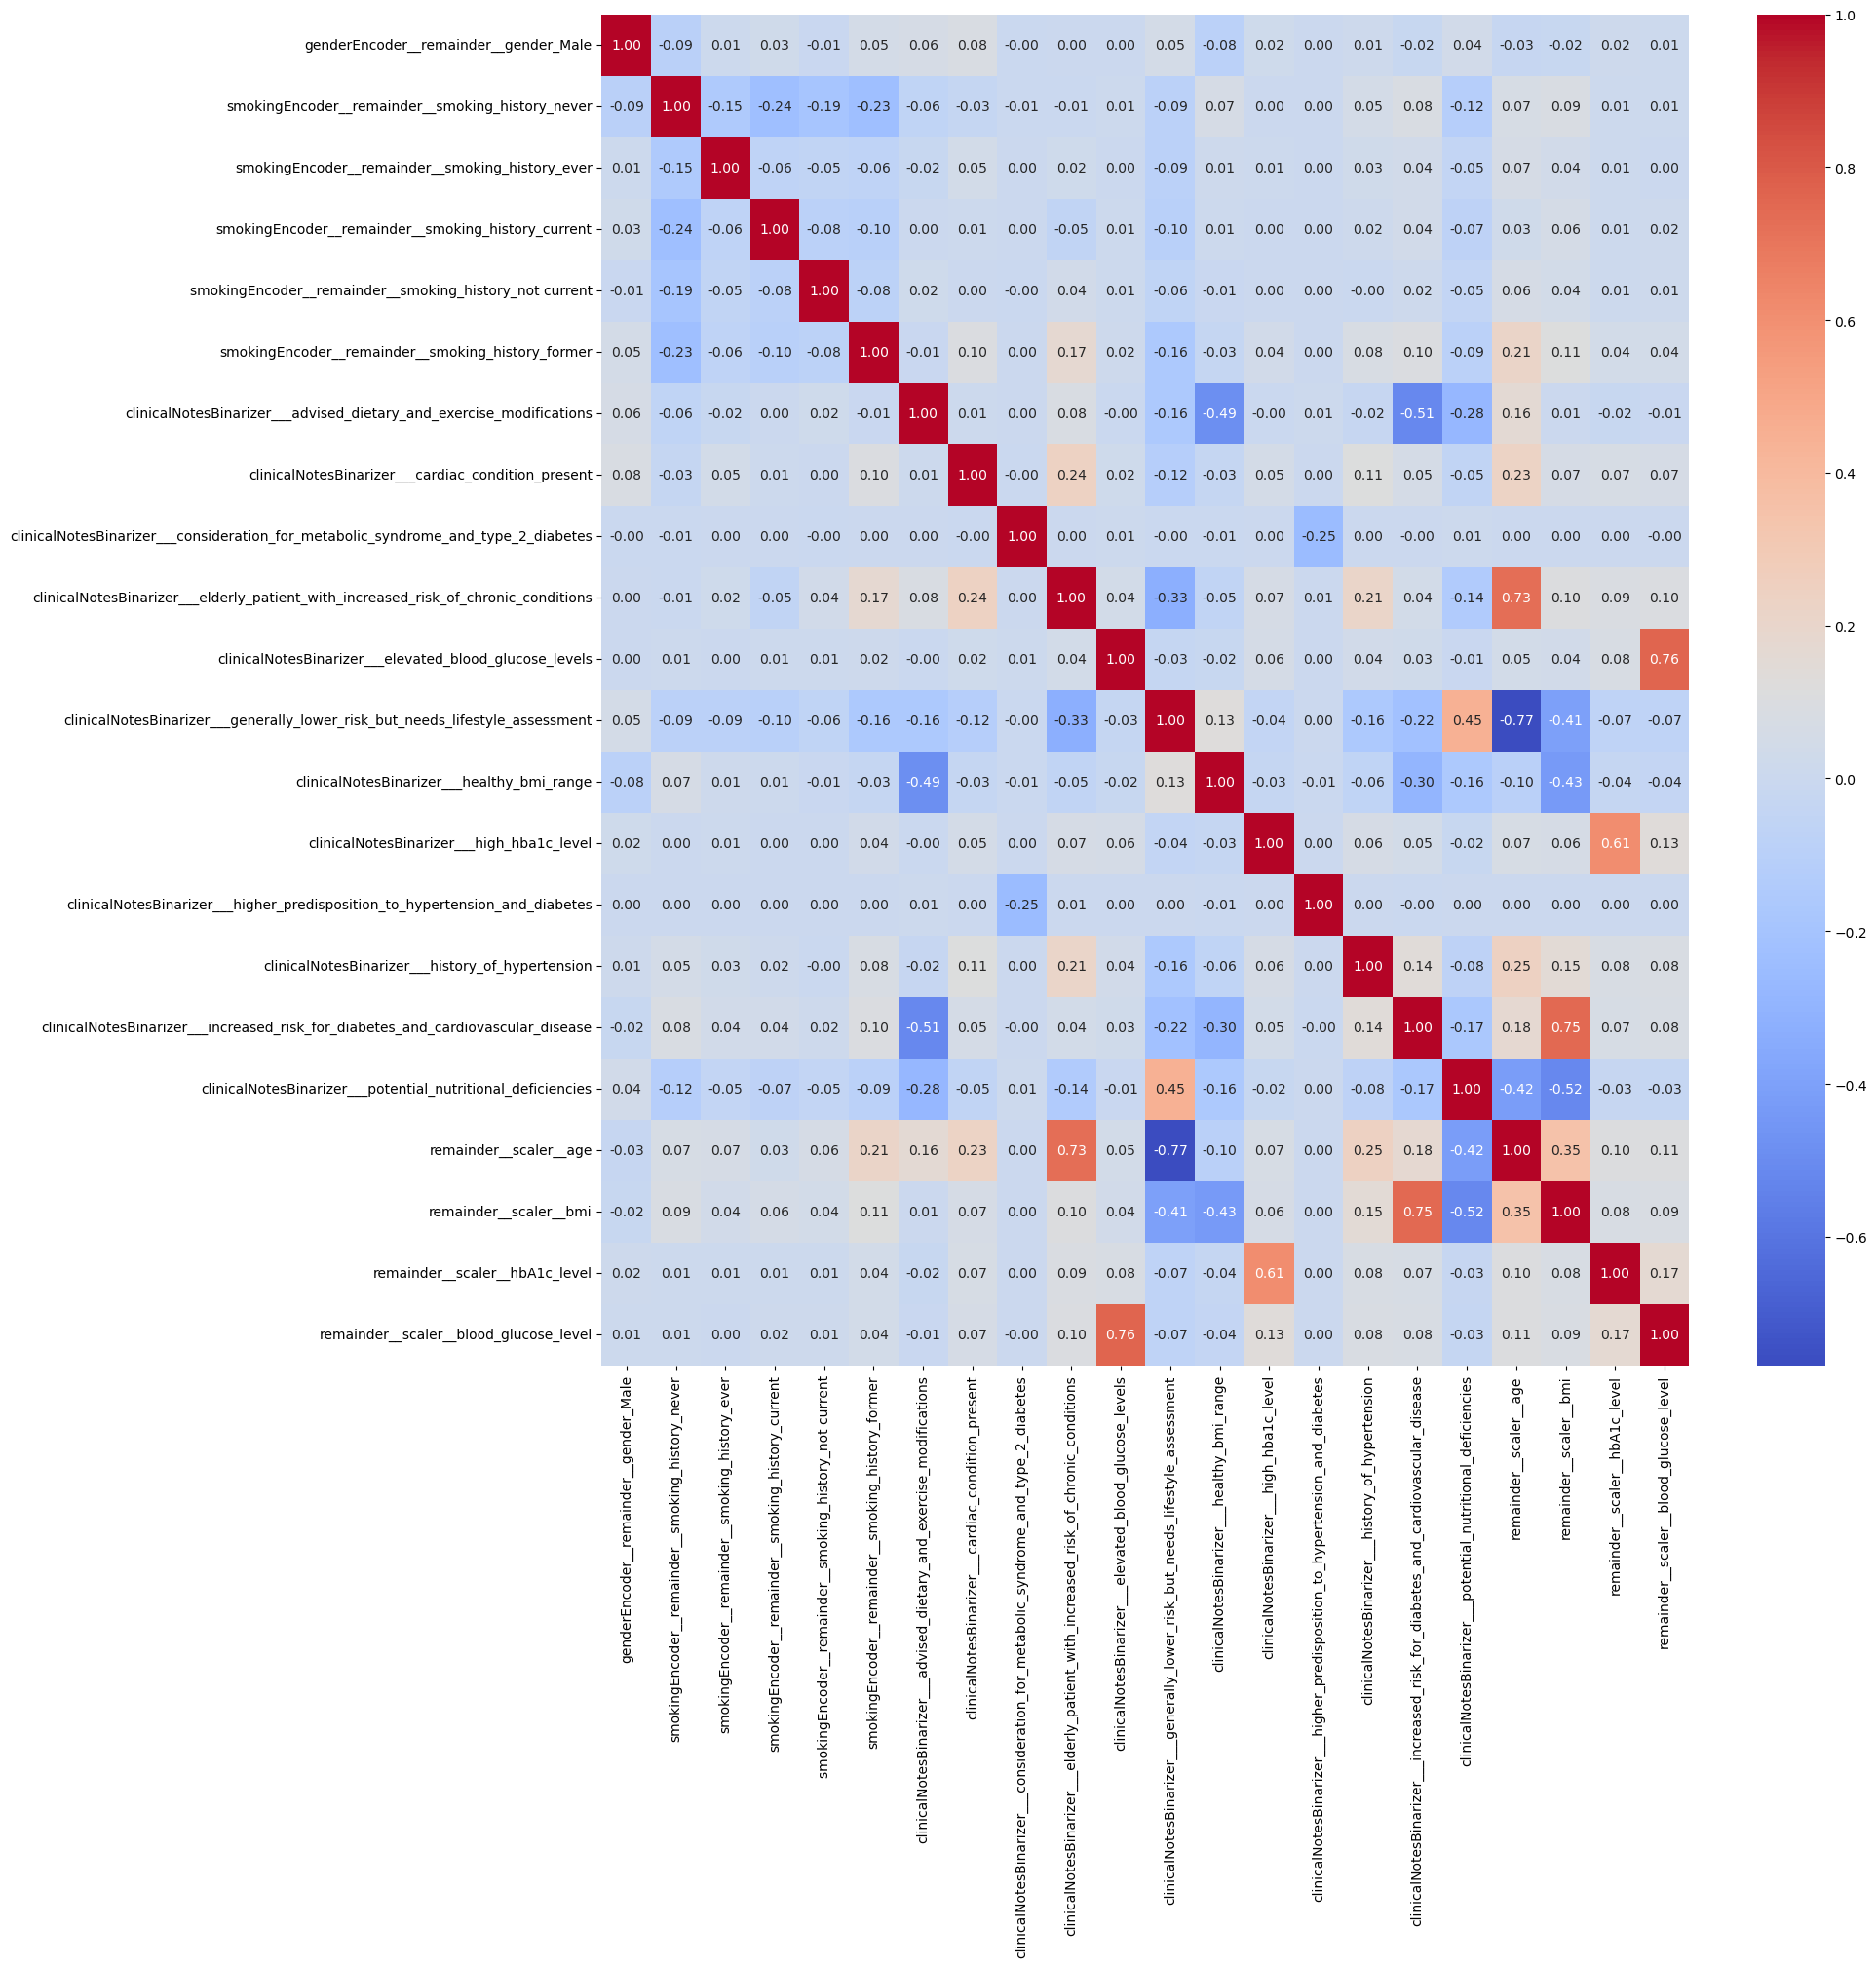

In [46]:
plt.figure(figsize=(18, 18))
sns.heatmap(X_train_transformed_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

To make modelling easier we wrote a function which fit and predicts y_train and y_test. Then we use some metrics to evaluate the results.The metrics we use:
DOPISZ JAK BEDZIEMY PEWNE
As stated in our business goal we want to put more emphasis on not missing people with diabetes. It's more damaging to miss an existing diabetes than to detect not present diabetes. That's why we want to maximise recall, but that often leads to predicting high number of false positives which can be expensive and also have negative implications. The key is to maintain a reasonable balance between high recall and F2 score and other metrics.


$$
F_2 = \frac{(1 + 2^2) \cdot \text{Precision} \cdot \text{Recall}}{(2^2 \cdot \text{Precision}) + \text{Recall}}
$$

\]
The key difference between the F1-score and the F2-score is the weight given to recall. In the F1-score, recall and precision are weighted equally, while in the F2-score, recall is given more importance.

In [47]:
def specificity_score(cm):
    tn, fp, fn, tp = cm.ravel()  # Rozpakowanie wartości z confusion matrix
    return tn / (tn + fp)  # Specificity = TN / (TN + FP)

In [48]:
def scores_model(X_train_transformed_df, X_test_transformed_df, model):
    model.fit(X_train_transformed_df, y_train)
    
    y_train_pred = model.predict(X_train_transformed_df)
    y_test_pred = model.predict(X_test_transformed_df)
    y_train_scores = model.predict_proba(X_train_transformed_df)[:, 1]
    y_test_scores = model.predict_proba(X_test_transformed_df)[:, 1] 
    
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_scores)
    
    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)
    train_pr_auc = auc(recall_train, precision_train)  
    test_pr_auc = auc(recall_test, precision_test)  
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    train_prec = accuracy_score(y_train, y_train_pred)
    test_prec = accuracy_score(y_test, y_test_pred)
    cfm_train = confusion_matrix(y_train, y_train_pred)
    cfm = confusion_matrix(y_test, y_test_pred)
    train_f2 = fbeta_score(y_train, y_train_pred, beta=2)
    test_f2 = fbeta_score(y_test, y_test_pred, beta=2)
    train_specificity = specificity_score(cfm_train)
    test_specificity = specificity_score(cfm)
    
    print("\nModel Performance:")
    print(f"Training Recall Score: {train_recall:.4f}")
    print(f"Test Recall Score: {test_recall:.4f}")
    print(f"Training F2 Score: {train_f2:.4f}")
    print(f"Test F2 Score: {test_f2:.4f}")
    print(f"Training Specificity Score: {train_specificity:.4f}")
    print(f"Test Specificity Score: {test_specificity:.4f}")
    print(f"Training ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"Training PR-AUC: {train_pr_auc:.4f}")
    print(f"Test PR-AUC: {test_pr_auc:.4f}")
    print(f"Training Accuracy Score: {train_prec:.4f}")
    print(f"Test Accuracy Score: {test_prec:.4f}")
    print("Test Confusion Matrix:\n", cfm)
    disp = ConfusionMatrixDisplay(cfm)
    disp.plot()
    plt.show()
    return (train_roc_auc, test_roc_auc, train_pr_auc, test_pr_auc, train_recall, test_recall, train_f2, test_f2, train_prec, test_prec, train_specificity, test_specificity)

We tested several models and adjusted their hyperparameters to achieve the best results. Some models performed poorly, while others delivered great results.

**Logistic Regression**


Model Performance:
Training Recall Score: 0.6291
Test Recall Score: 0.6336
Training F2 Score: 0.6678
Test F2 Score: 0.6719
Training Specificity Score: 0.9925
Test Specificity Score: 0.9924
Training ROC-AUC: 0.8108
Test ROC-AUC: 0.8130
Training PR-AUC: 0.8255
Test PR-AUC: 0.8310
Training Accuracy Score: 0.9616
Test Accuracy Score: 0.9619
Test Confusion Matrix:
 [[19069   146]
 [  654  1131]]


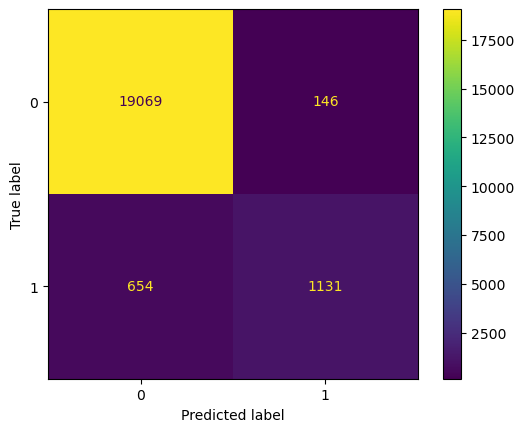

(0.810778737724598,
 0.8130076074145506,
 0.8254827428707748,
 0.8309939154416266,
 0.6290516206482593,
 0.6336134453781512,
 0.6678221859706363,
 0.671854580016633,
 0.9616122448979592,
 0.9619047619047619,
 0.9925058548009368,
 0.9924017694509498)

In [49]:
model = LogisticRegression()
scores_model(X_train_transformed_df, X_test_transformed_df, model)


Model Performance:
Training Recall Score: 0.8910
Test Recall Score: 0.9025
Training F2 Score: 0.7298
Test F2 Score: 0.7347
Training Specificity Score: 0.8873
Test Specificity Score: 0.8848
Training ROC-AUC: 0.8891
Test ROC-AUC: 0.8937
Training PR-AUC: 0.8233
Test PR-AUC: 0.8289
Training Accuracy Score: 0.8876
Test Accuracy Score: 0.8863
Test Confusion Matrix:
 [[17002  2213]
 [  174  1611]]


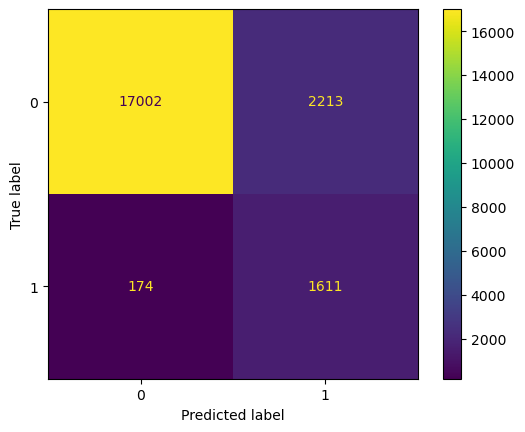

(0.8891248302599728,
 0.8936752843213788,
 0.8233054034123571,
 0.8289386583993921,
 0.8909963985594238,
 0.9025210084033614,
 0.7297648076771809,
 0.7346771251368114,
 0.8875714285714286,
 0.8863333333333333,
 0.8872532619605219,
 0.8848295602393963)

In [50]:
lr_best = LogisticRegression(class_weight='balanced', random_state=32)
scores_model(X_train_transformed_df, X_test_transformed_df, lr_best)

In [51]:
sel = SelectKBest(f_classif, k=15)
X_train_sel = sel.fit_transform(X_train_transformed_df, y_train)
X_test_sel = sel.transform(X_test_transformed_df)

columns = X_train_transformed_df.columns.tolist()
selected_columns = np.array(columns)[sel.get_support()].tolist()

print("Selected features:", selected_columns)

Selected features: ['smokingEncoder__remainder__smoking_history_former', 'clinicalNotesBinarizer___advised_dietary_and_exercise_modifications', 'clinicalNotesBinarizer___cardiac_condition_present', 'clinicalNotesBinarizer___elderly_patient_with_increased_risk_of_chronic_conditions', 'clinicalNotesBinarizer___elevated_blood_glucose_levels', 'clinicalNotesBinarizer___generally_lower_risk_but_needs_lifestyle_assessment', 'clinicalNotesBinarizer___healthy_bmi_range', 'clinicalNotesBinarizer___high_hba1c_level', 'clinicalNotesBinarizer___history_of_hypertension', 'clinicalNotesBinarizer___increased_risk_for_diabetes_and_cardiovascular_disease', 'clinicalNotesBinarizer___potential_nutritional_deficiencies', 'remainder__scaler__age', 'remainder__scaler__bmi', 'remainder__scaler__hbA1c_level', 'remainder__scaler__blood_glucose_level']



Model Performance:
Training Recall Score: 0.8879
Test Recall Score: 0.8986
Training F2 Score: 0.7261
Test F2 Score: 0.7296
Training Specificity Score: 0.8861
Test Specificity Score: 0.8830
Training ROC-AUC: 0.8870
Test ROC-AUC: 0.8908
Training PR-AUC: 0.8199
Test PR-AUC: 0.8273
Training Accuracy Score: 0.8862
Test Accuracy Score: 0.8843
Test Confusion Matrix:
 [[16967  2248]
 [  181  1604]]


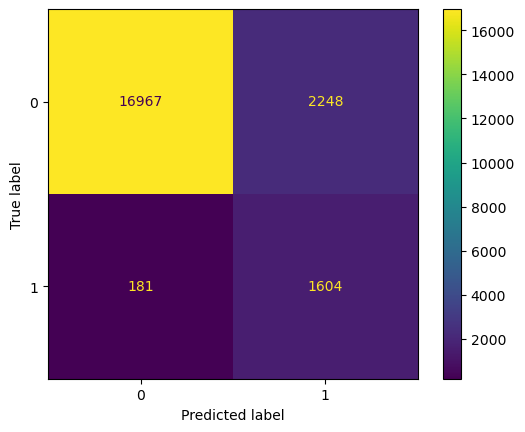

(0.8869843019174884,
 0.8908037531952671,
 0.8198885197689099,
 0.827260161369482,
 0.887875150060024,
 0.8985994397759104,
 0.7260946397015512,
 0.7296215429403202,
 0.8862448979591837,
 0.8843333333333333,
 0.8860934537749526,
 0.8830080666146239)

In [52]:
model = LogisticRegression(class_weight='balanced')
scores_model(X_train_sel, X_test_sel, model)


Model Performance:
Training Recall Score: 0.8905
Test Recall Score: 0.9025
Training F2 Score: 0.7292
Test F2 Score: 0.7343
Training Specificity Score: 0.8871
Test Specificity Score: 0.8846
Training ROC-AUC: 0.8888
Test ROC-AUC: 0.8935
Training PR-AUC: 0.8233
Test PR-AUC: 0.8290
Training Accuracy Score: 0.8874
Test Accuracy Score: 0.8861
Test Confusion Matrix:
 [[16997  2218]
 [  174  1611]]


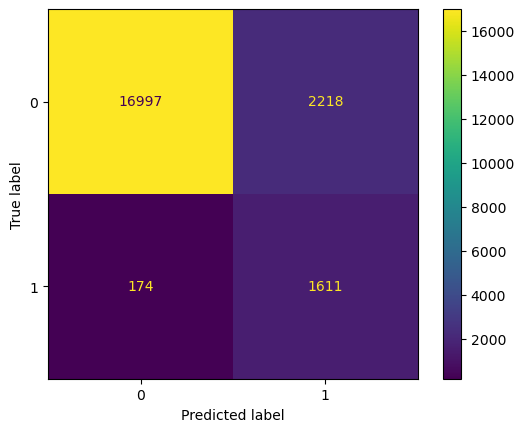

(0.8888066702090672,
 0.893545177633895,
 0.8233377305854888,
 0.8289891805488439,
 0.890516206482593,
 0.9025210084033614,
 0.7292281074279423,
 0.7343422372139666,
 0.8873877551020408,
 0.886095238095238,
 0.8870971339355415,
 0.8845693468644288)

In [53]:
model = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, model)

**KNN**


Model Performance:
Training Recall Score: 0.6106
Test Recall Score: 0.5838
Training F2 Score: 0.6577
Test F2 Score: 0.6288
Training Specificity Score: 0.9971
Test Specificity Score: 0.9946
Training ROC-AUC: 0.8038
Test ROC-AUC: 0.7892
Training PR-AUC: 0.8892
Test PR-AUC: 0.7988
Training Accuracy Score: 0.9642
Test Accuracy Score: 0.9597
Test Confusion Matrix:
 [[19112   103]
 [  743  1042]]


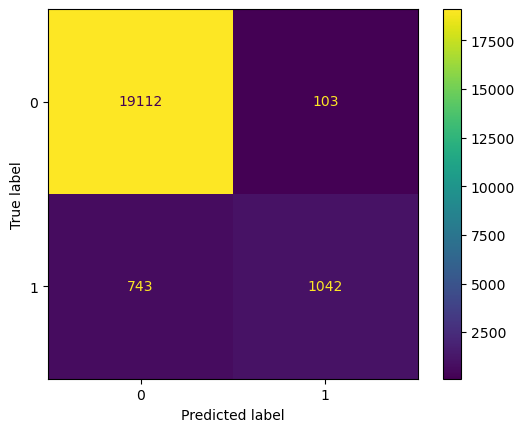

(0.8038323526131764,
 0.7891965529381152,
 0.8892429213467883,
 0.7987520894198481,
 0.6105642256902761,
 0.5837535014005603,
 0.6576837531681581,
 0.6288473144236573,
 0.9642448979591837,
 0.9597142857142857,
 0.9971004795360767,
 0.99463960447567)

In [54]:
model = KNeighborsClassifier(n_neighbors = 7)
scores_model(X_train_transformed_df, X_test_transformed_df, model)

Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.

Model Performance:
Training Recall Score: 0.8896
Test Recall Score: 0.9020
Training F2 Score: 0.7292
Test F2 Score: 0.7341
Training Specificity Score: 0.8876
Test Specificity Score: 0.8847
Training ROC-AUC: 0.8886
Test ROC-AUC: 0.8933
Training PR-AUC: 0.8236
Test PR-AUC: 0.8294
Training Accuracy Score: 0.8878
Test Accuracy Score: 0.8861
Test Confusion Matrix:
 [[16999  2216]
 [  175  1610]]


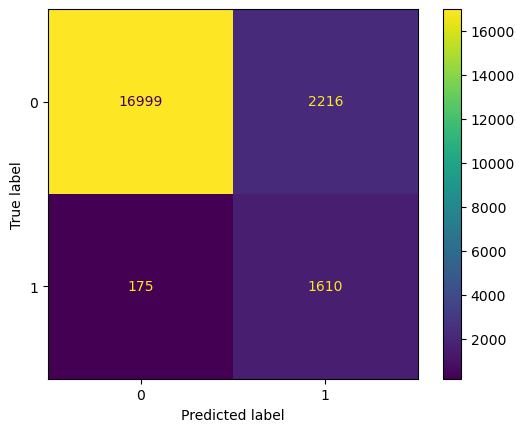

(0.8885718221714917,
 0.8933171082640706,
 0.8235557633566688,
 0.8293514363959009,
 0.8895558223289316,
 0.9019607843137255,
 0.7291871678803385,
 0.7340871785518877,
 0.8877551020408163,
 0.8861428571428571,
 0.8875878220140515,
 0.8846734322144159)

In [55]:
rfe = RFE(estimator = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced'), n_features_to_select=16, verbose=1)
scores_model(X_train_transformed_df, X_test_transformed_df, rfe)


Model Performance:
Training Recall Score: 0.8860
Test Recall Score: 0.8969
Training F2 Score: 0.7173
Test F2 Score: 0.7231
Training Specificity Score: 0.8802
Test Specificity Score: 0.8787
Training ROC-AUC: 0.8831
Test ROC-AUC: 0.8878
Training PR-AUC: 0.8148
Test PR-AUC: 0.8214
Training Accuracy Score: 0.8807
Test Accuracy Score: 0.8803
Test Confusion Matrix:
 [[16885  2330]
 [  184  1601]]


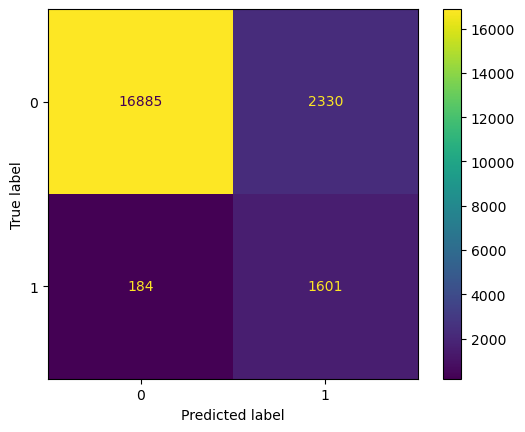

(0.883068637290982,
 0.88782966738608,
 0.8148046887663917,
 0.8214140922381276,
 0.885954381752701,
 0.8969187675070028,
 0.7172848145556333,
 0.7230602474934513,
 0.8806734693877551,
 0.8802857142857143,
 0.8801828928292629,
 0.8787405672651575)

In [56]:
X_train_transformed_df.var()
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train_transformed_df)
mask = sel.get_support()
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
model = LogisticRegression(class_weight='balanced')
scores_model(X_train_sel, X_test_sel, model)

The results with Variance Treshold are worse than only Logistic Regression

**RandomisedSearchCV for DecisionTreeClassifier**

Best parameters: {'min_samples_split': 14, 'min_samples_leaf': 0.05, 'max_features': 8, 'max_depth': 4, 'criterion': 'entropy'}

Best model scores:

Model Performance:
Training Recall Score: 0.9806
Test Recall Score: 0.9787
Training F2 Score: 0.6040
Test F2 Score: 0.6055
Training Specificity Score: 0.7086
Test Specificity Score: 0.7118
Training ROC-AUC: 0.8446
Test ROC-AUC: 0.8452
Training PR-AUC: 0.5856
Test PR-AUC: 0.5830
Training Accuracy Score: 0.7317
Test Accuracy Score: 0.7345
Test Confusion Matrix:
 [[13677  5538]
 [   38  1747]]


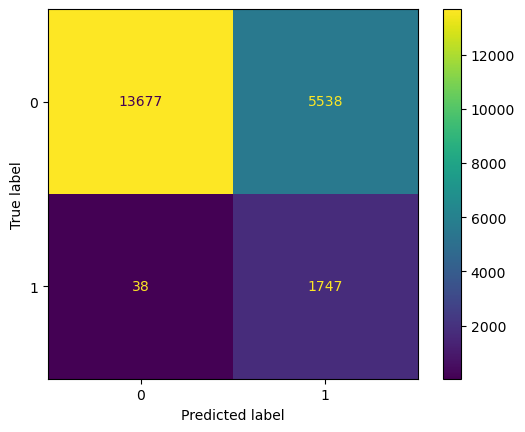

(0.8445752071320332,
 0.845249575239932,
 0.585551967722438,
 0.5830478170911129,
 0.9805522208883554,
 0.9787114845938375,
 0.6039811884409477,
 0.6055459272097053,
 0.7317142857142858,
 0.7344761904761905,
 0.708598193375711,
 0.7117876658860265)

In [57]:
def pr_auc_scorer(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)
    
param_dist = {
    "max_depth" : range(2, 20),
    "max_features" : range(2, 10),
    "min_samples_split" : range(2, 20),
    'min_samples_leaf': [0.05, 0.1, 0.15, 0.2],
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(class_weight='balanced', random_state=32)
scoring = {
    'roc_auc': 'roc_auc', 
    'pr_auc': make_scorer(pr_auc_scorer),
    'recall': 'recall' 
}

random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scoring, random_state=42, n_jobs=-1, refit='recall')

random_search.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search.best_params_)

dtc_best = random_search.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, dtc_best)

**Voting Classifier**


Model Performance:
Training Recall Score: 0.8831
Test Recall Score: 0.8784
Training F2 Score: 0.5696
Test F2 Score: 0.5691
Training Specificity Score: 0.7335
Test Specificity Score: 0.7363
Training ROC-AUC: 0.8083
Test ROC-AUC: 0.8074
Training PR-AUC: 0.5127
Test PR-AUC: 0.5049
Training Accuracy Score: 0.7462
Test Accuracy Score: 0.7484
Test Confusion Matrix:
 [[14148  5067]
 [  217  1568]]


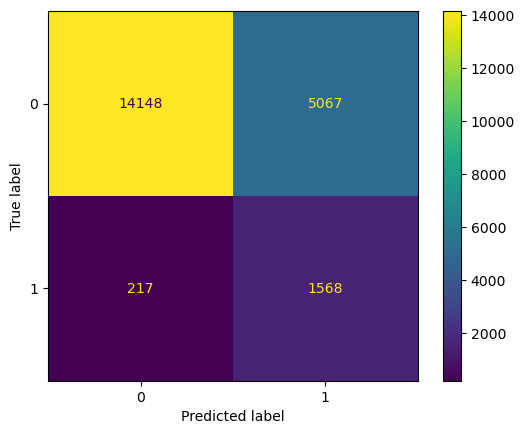

In [58]:
lr = LogisticRegression(class_weight='balanced')

knn = KNeighborsClassifier(n_neighbors=9)

dt = DecisionTreeClassifier(max_depth = 15, min_samples_leaf=0.1, random_state=2, max_features = 15, class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, dt)

classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]

Logistic Regression

Model Performance:
Training Recall Score: 0.8910
Test Recall Score: 0.9025
Training F2 Score: 0.7298
Test F2 Score: 0.7347
Training Specificity Score: 0.8873
Test Specificity Score: 0.8848
Training ROC-AUC: 0.8891
Test ROC-AUC: 0.8937
Training PR-AUC: 0.8233
Test PR-AUC: 0.8289
Training Accuracy Score: 0.8876
Test Accuracy Score: 0.8863
Test Confusion Matrix:
 [[17002  2213]
 [  174  1611]]


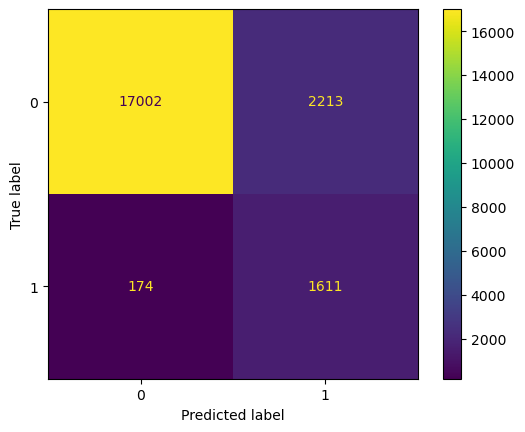

K Nearest Neighbours

Model Performance:
Training Recall Score: 0.5904
Test Recall Score: 0.5720
Training F2 Score: 0.6398
Test F2 Score: 0.6198
Training Specificity Score: 0.9978
Test Specificity Score: 0.9961
Training ROC-AUC: 0.7941
Test ROC-AUC: 0.7840
Training PR-AUC: 0.8813
Test PR-AUC: 0.8023
Training Accuracy Score: 0.9632
Test Accuracy Score: 0.9600
Test Confusion Matrix:
 [[19140    75]
 [  764  1021]]


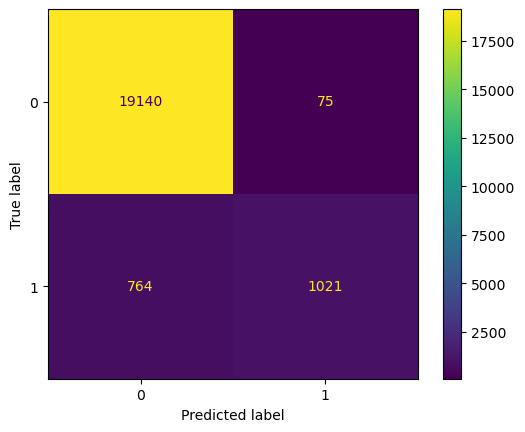

Classification Tree

Model Performance:
Training Recall Score: 0.8831
Test Recall Score: 0.8784
Training F2 Score: 0.5696
Test F2 Score: 0.5691
Training Specificity Score: 0.7335
Test Specificity Score: 0.7363
Training ROC-AUC: 0.8083
Test ROC-AUC: 0.8074
Training PR-AUC: 0.5127
Test PR-AUC: 0.5049
Training Accuracy Score: 0.7462
Test Accuracy Score: 0.7484
Test Confusion Matrix:
 [[14148  5067]
 [  217  1568]]


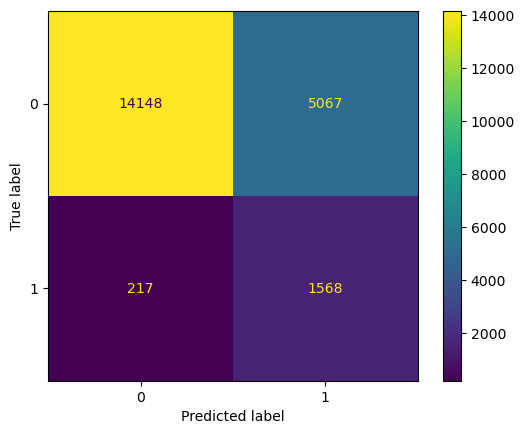

Voting classifier:

Model Performance:
Training Recall Score: 0.8435
Test Recall Score: 0.8246
Training F2 Score: 0.7672
Test F2 Score: 0.7505
Training Specificity Score: 0.9393
Test Specificity Score: 0.9378
Training ROC-AUC: 0.8914
Test ROC-AUC: 0.8812
Training PR-AUC: 0.8488
Test PR-AUC: 0.8250
Training Accuracy Score: 0.9312
Test Accuracy Score: 0.9282
Test Confusion Matrix:
 [[18020  1195]
 [  313  1472]]


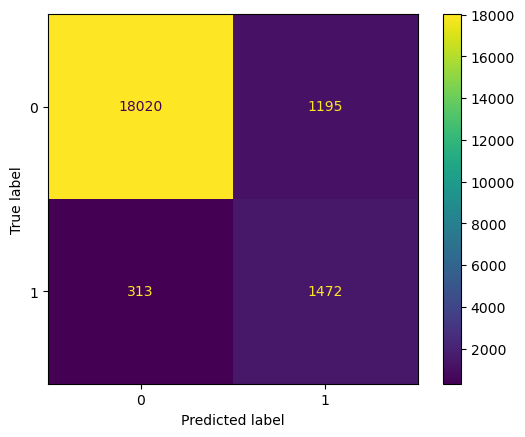

(0.8913840946214552,
 0.8812294316633756,
 0.8488106928380809,
 0.8249784431182627,
 0.8434573829531813,
 0.8246498599439775,
 0.7672315890626364,
 0.7504843479147547,
 0.9311632653061225,
 0.9281904761904762,
 0.939310806289729,
 0.9378090033827738)

In [59]:
for clf_name, model in classifiers:    
    print(clf_name)
    scores_model(X_train_transformed_df, X_test_transformed_df, model)
vc = VotingClassifier(estimators=classifiers, voting='soft') 
print('Voting classifier:')
scores_model(X_train_transformed_df, X_test_transformed_df, vc)

**Random Forest Classifier**


Model Performance:
Training Recall Score: 0.9388
Test Recall Score: 0.8773
Training F2 Score: 0.8305
Test F2 Score: 0.7768
Training Specificity Score: 0.9338
Test Specificity Score: 0.9285
Training ROC-AUC: 0.9363
Test ROC-AUC: 0.9029
Training PR-AUC: 0.9287
Test PR-AUC: 0.8785
Training Accuracy Score: 0.9342
Test Accuracy Score: 0.9241
Test Confusion Matrix:
 [[17841  1374]
 [  219  1566]]


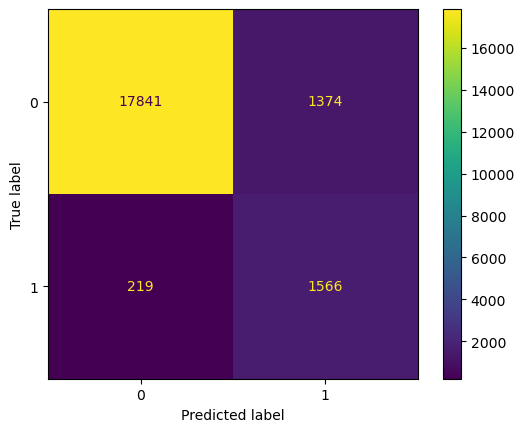

(0.9362663098026096,
 0.9029021444643431,
 0.9287170496506657,
 0.8785326233422089,
 0.9387755102040817,
 0.8773109243697479,
 0.8305012744265081,
 0.7767857142857143,
 0.9341836734693878,
 0.9241428571428572,
 0.9337571094011375,
 0.9284933645589384)

In [60]:
rf = RandomForestClassifier(max_depth=13, class_weight='balanced')
scores_model(X_train_transformed_df, X_test_transformed_df, rf)


Model Performance:
Training Recall Score: 0.9378
Test Recall Score: 0.8723
Training F2 Score: 0.8270
Test F2 Score: 0.7708
Training Specificity Score: 0.9320
Test Specificity Score: 0.9270
Training ROC-AUC: 0.9349
Test ROC-AUC: 0.8996
Training PR-AUC: 0.9263
Test PR-AUC: 0.8767
Training Accuracy Score: 0.9325
Test Accuracy Score: 0.9223
Test Confusion Matrix:
 [[17812  1403]
 [  228  1557]]


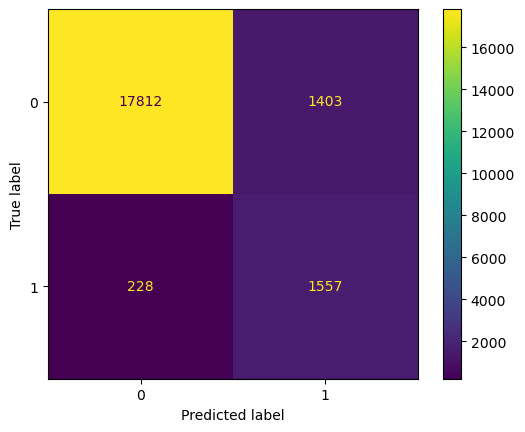

(0.9349051095848175,
 0.8996265172735761,
 0.9262596953311106,
 0.8766607152318816,
 0.9378151260504202,
 0.8722689075630252,
 0.8270167266567859,
 0.7707920792079208,
 0.9324897959183673,
 0.9223333333333333,
 0.9319950931192149,
 0.926984126984127)

In [61]:
sel = SelectKBest(f_classif, k=15)
X_train_sel = sel.fit_transform(X_train_transformed_df, y_train)
X_test_sel = sel.transform(X_test_transformed_df)
scores_model(X_train_sel, X_test_sel, rf)


Model Performance:
Training Recall Score: 0.9421
Test Recall Score: 0.8706
Training F2 Score: 0.8402
Test F2 Score: 0.7772
Training Specificity Score: 0.9383
Test Specificity Score: 0.9321
Training ROC-AUC: 0.9402
Test ROC-AUC: 0.9014
Training PR-AUC: 0.9308
Test PR-AUC: 0.8786
Training Accuracy Score: 0.9386
Test Accuracy Score: 0.9269
Test Confusion Matrix:
 [[17911  1304]
 [  231  1554]]


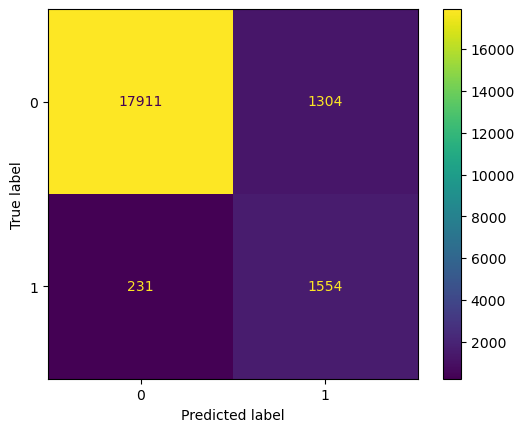

(0.9401996864319498,
 0.9013622935513003,
 0.9307721356683988,
 0.8786397042164354,
 0.9421368547418968,
 0.8705882352941177,
 0.8401849948612539,
 0.7771554310862172,
 0.9385918367346939,
 0.9269047619047619,
 0.9382625181220029,
 0.932136351808483)

In [62]:
X_train_transformed_df.var()
sel = VarianceThreshold(threshold=0.1)
sel.fit(X_train_transformed_df)
mask = sel.get_support()
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
scores_model(X_train_sel, X_test_sel, rf)


Model Performance:
Training Recall Score: 0.9390
Test Recall Score: 0.8745
Training F2 Score: 0.8326
Test F2 Score: 0.7758
Training Specificity Score: 0.9350
Test Specificity Score: 0.9292
Training ROC-AUC: 0.9370
Test ROC-AUC: 0.9019
Training PR-AUC: 0.9300
Test PR-AUC: 0.8794
Training Accuracy Score: 0.9353
Test Accuracy Score: 0.9246
Test Confusion Matrix:
 [[17855  1360]
 [  224  1561]]


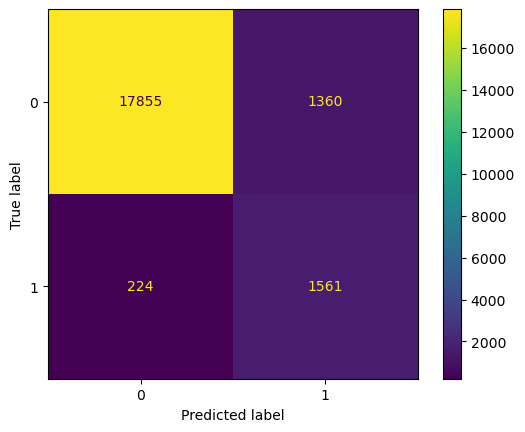

[0.0050606  0.00343597 0.00224863 0.00301052 0.00257153 0.00416787
 0.003728   0.00857145 0.00351717 0.04129273 0.0638696  0.03088005
 0.00562749 0.08143054 0.00329029 0.01689465 0.02029782 0.00337912
 0.11444876 0.05385277 0.29423422 0.23419023]

Model Performance:
Training Recall Score: 0.9357
Test Recall Score: 0.8818
Training F2 Score: 0.7900
Test F2 Score: 0.7448
Training Specificity Score: 0.9084
Test Specificity Score: 0.9036
Training ROC-AUC: 0.9220
Test ROC-AUC: 0.8927
Training PR-AUC: 0.8934
Test PR-AUC: 0.8592
Training Accuracy Score: 0.9107
Test Accuracy Score: 0.9018
Test Confusion Matrix:
 [[17363  1852]
 [  211  1574]]


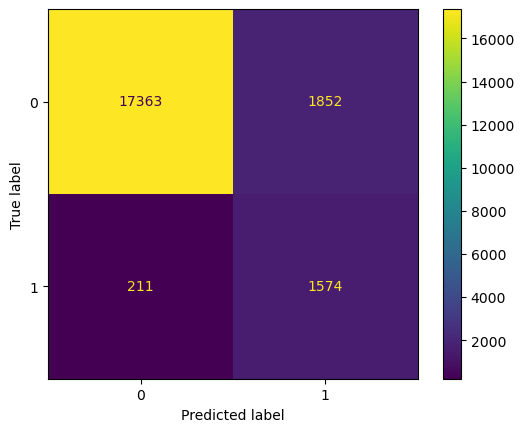

(0.9220035555205689,
 0.8927048414994413,
 0.8934378064504639,
 0.8591728326058826,
 0.9356542617046819,
 0.8817927170868347,
 0.7899537825346631,
 0.7448419458640924,
 0.9106734693877551,
 0.9017619047619048,
 0.9083528493364559,
 0.9036169659120479)

In [63]:
scores_model(X_train_transformed_df, X_test_transformed_df, rf)
print(rf.feature_importances_)
mask = rf.feature_importances_ > 0.06
X_train_sel = X_train_transformed_df.loc[:, mask]
X_test_sel = X_test_transformed_df.loc[:, mask]
scores_model(X_train_sel, X_test_sel, rf)

Fitting estimator with 22 features.
Fitting estimator with 17 features.
Fitting estimator with 12 features.

Model Performance:
Training Recall Score: 0.9436
Test Recall Score: 0.8678
Training F2 Score: 0.8448
Test F2 Score: 0.7778
Training Specificity Score: 0.9404
Test Specificity Score: 0.9340
Training ROC-AUC: 0.9420
Test ROC-AUC: 0.9009
Training PR-AUC: 0.9330
Test PR-AUC: 0.8771
Training Accuracy Score: 0.9407
Test Accuracy Score: 0.9283
Test Confusion Matrix:
 [[17946  1269]
 [  236  1549]]


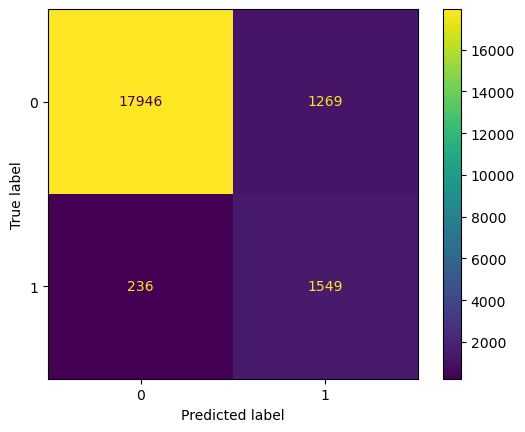

(0.9420128707220594,
 0.9008724801395969,
 0.9329557422090307,
 0.8770997068970734,
 0.943577430972389,
 0.8677871148459384,
 0.8447979363714532,
 0.7777666198031733,
 0.9407142857142857,
 0.9283333333333333,
 0.9404483104717297,
 0.9339578454332552)

In [64]:
rfe = RFE(estimator=rf, n_features_to_select=8, verbose=1, step=5)
scores_model(X_train_transformed_df, X_test_transformed_df, rfe)

[0.26026325 0.43996261 0.5796008  0.70175682 0.75437267 0.79355488
 0.82689059 0.85720648 0.87952059 0.89768802 0.91357461 0.92823281
 0.94141713 0.9541003  0.96523757 0.97465769 0.98210941 0.98733193
 0.99207206 0.99633129 1.         1.        ]


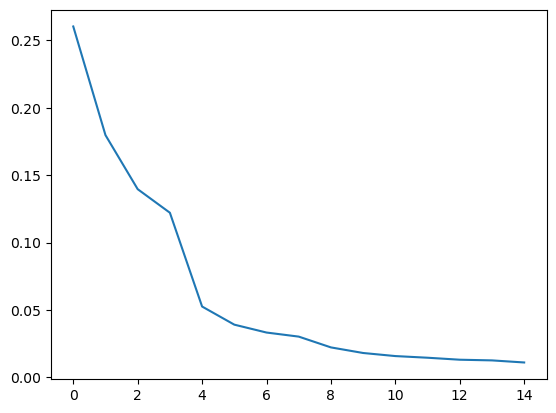

In [65]:
pipelinePCA = Pipeline([
    ('reducer', PCA(n_components=15)),
    ('classifier', rf)
])
pca = PCA()
pca.fit_transform(X_train_transformed_df, y_train)
print(pca.explained_variance_ratio_.cumsum())
pipelinePCA.fit(X_train_transformed, y_train)
plt.plot(pipelinePCA['reducer'].explained_variance_ratio_)


Model Performance:
Training Recall Score: 0.9551
Test Recall Score: 0.8331
Training F2 Score: 0.8763
Test F2 Score: 0.7679
Training Specificity Score: 0.9540
Test Specificity Score: 0.9451
Training ROC-AUC: 0.9546
Test ROC-AUC: 0.8891
Training PR-AUC: 0.9379
Test PR-AUC: 0.8580
Training Accuracy Score: 0.9541
Test Accuracy Score: 0.9356
Test Confusion Matrix:
 [[18160  1055]
 [  298  1487]]


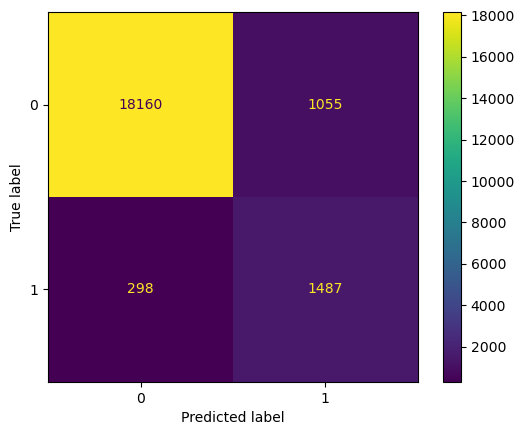

(0.9545667447306792,
 0.8890740995851893,
 0.9378552548482953,
 0.8579727190952461,
 0.9551020408163265,
 0.8330532212885154,
 0.8762500550685052,
 0.7679198512703986,
 0.9541224489795919,
 0.9355714285714286,
 0.9540314486450318,
 0.9450949778818631)

In [66]:
pipelinePCA2 = Pipeline([
    ('reducer', PCA(n_components=5)),
    ('classifier', rf)
])
scores_model(X_train_transformed_df, X_test_transformed_df, pipelinePCA2)

Here the best model for now: (I guess?)

Best parameters: {'n_estimators': 12, 'min_samples_split': 7, 'max_features': 8, 'max_depth': 8}

Best model scores:

Model Performance:
Training Recall Score: 0.9263
Test Recall Score: 0.9311
Training F2 Score: 0.7556
Test F2 Score: 0.7583
Training Specificity Score: 0.8882
Test Specificity Score: 0.8877
Training ROC-AUC: 0.9073
Test ROC-AUC: 0.9094
Training PR-AUC: 0.8762
Test PR-AUC: 0.8834
Training Accuracy Score: 0.8915
Test Accuracy Score: 0.8914
Test Confusion Matrix:
 [[17058  2157]
 [  123  1662]]


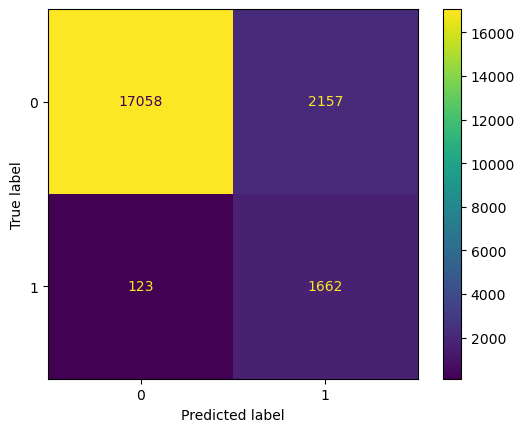

(0.9072625771620124,
 0.909418193506911,
 0.8761947663351486,
 0.8833673020218924,
 0.9262905162064826,
 0.9310924369747899,
 0.7556112656194915,
 0.7582808650424309,
 0.8914693877551021,
 0.8914285714285715,
 0.8882346381175421,
 0.8877439500390321)

In [67]:
param_dist = {"max_depth" : range(2, 20),
              "max_features" : range(2, 10),
              "min_samples_split" : range(2, 20),
              "n_estimators" : range(2, 100, 10)}

scorer = make_scorer(recall_score)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scorer, random_state=32)

random_search.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search.best_params_)

rf_best = random_search.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, rf_best)

**BaggingClassifier**


Model Performance:
Training Recall Score: 0.9258
Test Recall Score: 0.9249
Training F2 Score: 0.7579
Test F2 Score: 0.7564
Training Specificity Score: 0.8902
Test Specificity Score: 0.8895
Training ROC-AUC: 0.9080
Test ROC-AUC: 0.9072
Training PR-AUC: 0.8788
Test PR-AUC: 0.8848
Training Accuracy Score: 0.8932
Test Accuracy Score: 0.8925
Test Confusion Matrix:
 [[17092  2123]
 [  134  1651]]


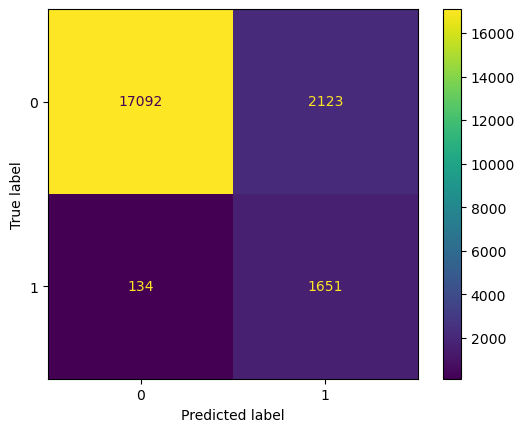

(0.9079927052788328,
 0.9072216864888032,
 0.8787651524717841,
 0.8847874171072887,
 0.9258103241296518,
 0.9249299719887956,
 0.7578616352201258,
 0.7563679677478468,
 0.8932040816326531,
 0.8925238095238095,
 0.8901750864280138,
 0.8895134009888108)

In [68]:
bagging_best = BaggingClassifier(estimator= rf_best,
                        n_estimators=15, random_state=32)
scores_model(X_train_transformed_df, X_test_transformed_df, bagging_best)

**AdaBoost**


Model Performance:
Training Recall Score: 0.6639
Test Recall Score: 0.6930
Training F2 Score: 0.7117
Test F2 Score: 0.7383
Training Specificity Score: 1.0000
Test Specificity Score: 1.0000
Training ROC-AUC: 0.8319
Test ROC-AUC: 0.8465
Training PR-AUC: 0.8679
Test PR-AUC: 0.8773
Training Accuracy Score: 0.9714
Test Accuracy Score: 0.9739
Test Confusion Matrix:
 [[19215     0]
 [  548  1237]]


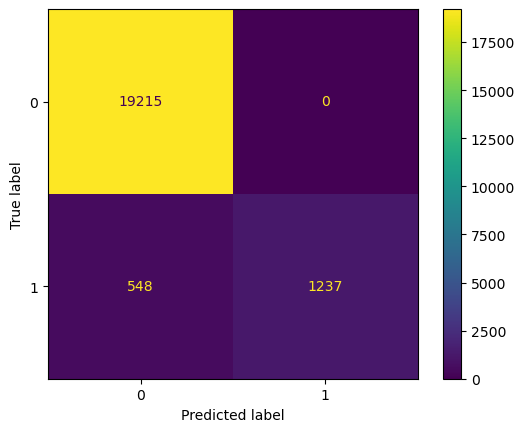

(0.8319327731092436,
 0.8464985994397759,
 0.8679404059139555,
 0.8773173872150284,
 0.6638655462184874,
 0.6929971988795518,
 0.7117117117117117,
 0.7383311448012415,
 0.9714285714285714,
 0.9739047619047619,
 1.0,
 1.0)

In [69]:
ada = AdaBoostClassifier()
scores_model(X_train_transformed_df, X_test_transformed_df, ada)

**GBoost**


Model Performance:
Training Recall Score: 0.9342
Test Recall Score: 0.9261
Training F2 Score: 0.7712
Test F2 Score: 0.7686
Training Specificity Score: 0.8957
Test Specificity Score: 0.8979
Training ROC-AUC: 0.9150
Test ROC-AUC: 0.9120
Training PR-AUC: 0.8857
Test PR-AUC: 0.8862
Training Accuracy Score: 0.8990
Test Accuracy Score: 0.9003
Test Confusion Matrix:
 [[17254  1961]
 [  132  1653]]


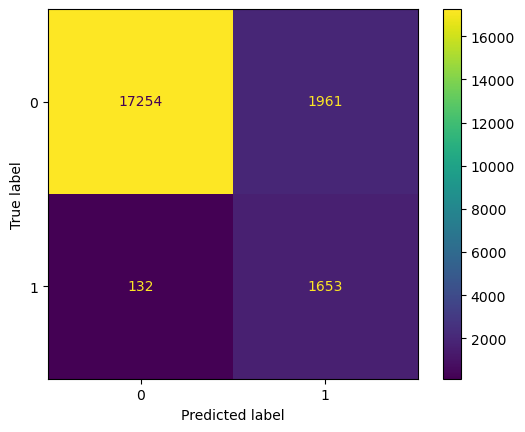

Best parameters: {'min_samples_leaf': 15, 'max_features': 0.4, 'max_depth': 14}

Best model scores:

Model Performance:
Training Recall Score: 0.9345
Test Recall Score: 0.9333
Training F2 Score: 0.7571
Test F2 Score: 0.7560
Training Specificity Score: 0.8851
Test Specificity Score: 0.8848
Training ROC-AUC: 0.9098
Test ROC-AUC: 0.9091
Training PR-AUC: 0.8839
Test PR-AUC: 0.8874
Training Accuracy Score: 0.8893
Test Accuracy Score: 0.8890
Test Confusion Matrix:
 [[17002  2213]
 [  119  1666]]


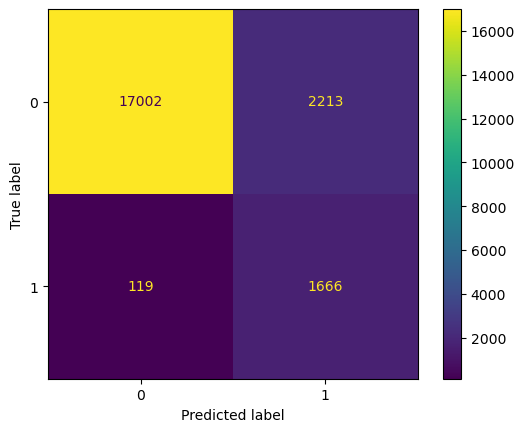

(0.9097940815670531,
 0.9090814467863648,
 0.8839088729933525,
 0.8874246888964272,
 0.934453781512605,
 0.9333333333333333,
 0.75713952221617,
 0.7559669661493783,
 0.8893265306122449,
 0.8889523809523809,
 0.885134381621501,
 0.8848295602393963)

In [70]:
gboost_best = HistGradientBoostingClassifier(learning_rate=0.01, class_weight='balanced', random_state=32)
scores_model(X_train_transformed_df, X_test_transformed_df, gboost_best)

# jak dla mnie lepiej działa ten pierwszy i ten search można usunąć

param_dist = {"max_depth" : range(2, 20),
              "max_features" : np.arange(0, 1.1, 0.1),
              "min_samples_leaf" : range(2, 20)}

scorer = make_scorer(recall_score)

random_search_boost = RandomizedSearchCV(estimator=gboost_best, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scorer)

random_search_boost.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search_boost.best_params_)

boost_best = random_search_boost.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, boost_best)

**XGBoost**


Model Performance:
Training Recall Score: 0.9974
Test Recall Score: 0.8028
Training F2 Score: 0.9494
Test F2 Score: 0.7625
Training Specificity Score: 0.9763
Test Specificity Score: 0.9571
Training ROC-AUC: 0.9868
Test ROC-AUC: 0.8800
Training PR-AUC: 0.9932
Test PR-AUC: 0.8645
Training Accuracy Score: 0.9781
Test Accuracy Score: 0.9440
Test Confusion Matrix:
 [[18391   824]
 [  352  1433]]


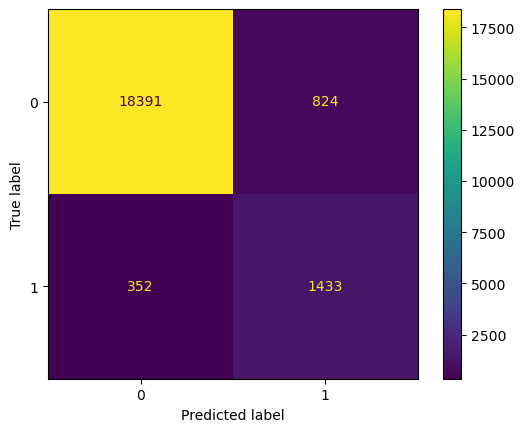


Model Performance:
Training Recall Score: 0.9188
Test Recall Score: 0.9255
Training F2 Score: 0.6552
Test F2 Score: 0.6571
Training Specificity Score: 0.8056
Test Specificity Score: 0.8033
Training ROC-AUC: 0.8622
Test ROC-AUC: 0.8644
Training PR-AUC: 0.7618
Test PR-AUC: 0.7645
Training Accuracy Score: 0.8152
Test Accuracy Score: 0.8137
Test Confusion Matrix:
 [[15436  3779]
 [  133  1652]]


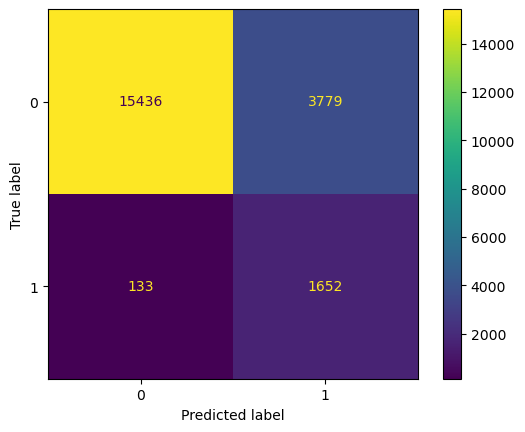

(0.8622229219556676,
 0.8644104636390075,
 0.7618049660488122,
 0.7645015473120663,
 0.9188475390156062,
 0.9254901960784314,
 0.6552408999075438,
 0.6570678545859517,
 0.8152244897959183,
 0.8137142857142857,
 0.8055983048957288,
 0.8033307311995836)

In [71]:
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

xgb=XGBClassifier(random_state=1,
                    learning_rate=0.01,
                    booster='gbtree',
                    max_depth=20,
                    scale_pos_weight=scale_pos_weight
                    )
scores_model(X_train_transformed_df, X_test_transformed_df, xgb)

xgb_best=XGBClassifier(random_state=1,
                    learning_rate=0.01,
                    booster='gblinear',
                    scale_pos_weight=scale_pos_weight
                    )
scores_model(X_train_transformed_df, X_test_transformed_df, xgb_best)

Best parameters: {'n_estimators': 20, 'min_child_weight': 7, 'max_depth': 19, 'learning_rate': 0.01, 'colsample_bytree': 0.4, 'booster': 'gblinear'}

Best model scores:

Model Performance:
Training Recall Score: 0.9731
Test Recall Score: 0.9681
Training F2 Score: 0.5256
Test F2 Score: 0.5227
Training Specificity Score: 0.6020
Test Specificity Score: 0.6014
Training ROC-AUC: 0.7876
Test ROC-AUC: 0.7847
Training PR-AUC: 0.7144
Test PR-AUC: 0.7144
Training Accuracy Score: 0.6336
Test Accuracy Score: 0.6325
Test Confusion Matrix:
 [[11555  7660]
 [   57  1728]]


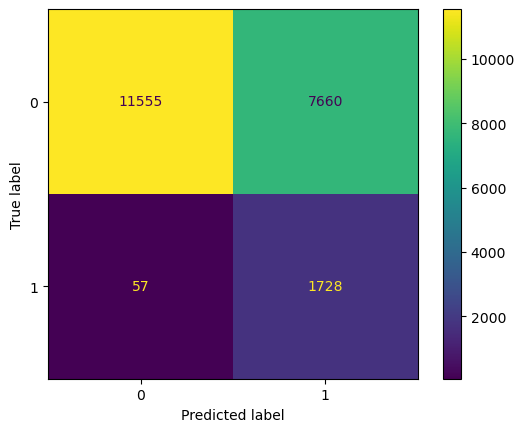

(0.7875583020093283,
 0.7847101682202935,
 0.7144292630239387,
 0.714416607239537,
 0.973109243697479,
 0.9680672268907563,
 0.52558549679695,
 0.5227492739593417,
 0.6335510204081632,
 0.6325238095238095,
 0.6020073603211776,
 0.6013531095498309)

In [72]:
xgb=XGBClassifier(random_state=1, scale_pos_weight=scale_pos_weight)

param_dist = {
    "max_depth": range(2, 20),
    "min_child_weight": range(1, 10),
    "n_estimators": range(10, 200, 10), 
    "colsample_bytree": [i / 10.0 for i in range(3, 10)],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "booster": ["gbtree", "gblinear"]
}

random_search_xgboost = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist, n_iter=10,
                                   cv=5, scoring=scorer)

random_search_xgboost.fit(X_train_transformed_df, y_train)

print("Best parameters:", random_search_xgboost.best_params_)

best_model_xgboost = random_search_xgboost.best_estimator_

print("\nBest model scores:")
scores_model(X_train_transformed_df, X_test_transformed_df, best_model_xgboost)

**Gaussain Naive Bayes**


Model Performance:
Training Recall Score: 0.8439
Test Recall Score: 0.8510
Training F2 Score: 0.6608
Test F2 Score: 0.6638
Training Specificity Score: 0.8568
Test Specificity Score: 0.8552
Training ROC-AUC: 0.8504
Test ROC-AUC: 0.8531
Training PR-AUC: 0.5791
Test PR-AUC: 0.5782
Training Accuracy Score: 0.8557
Test Accuracy Score: 0.8549
Test Confusion Matrix:
 [[16433  2782]
 [  266  1519]]


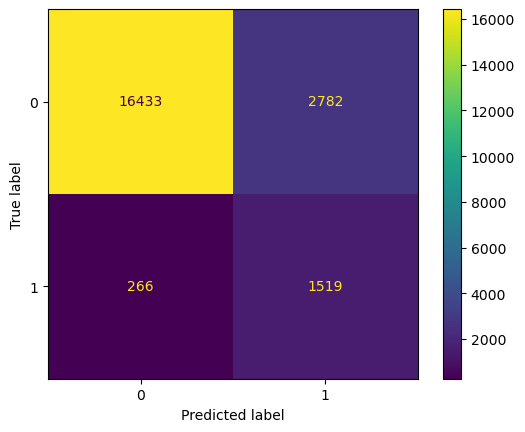

(0.8503617840578854,
 0.8530988351624802,
 0.5791326399852448,
 0.5781518468406931,
 0.843937575030012,
 0.8509803921568627,
 0.6608136561889005,
 0.6638405733764531,
 0.8556938775510204,
 0.8548571428571429,
 0.8567859930857589,
 0.8552172781680979)

In [73]:
bayes = GaussianNB()
scores_model(X_train_transformed_df, X_test_transformed_df, bayes)


Model Performance:
Training Recall Score: 0.9527
Test Recall Score: 0.9479
Training F2 Score: 0.5432
Test F2 Score: 0.5395
Training Specificity Score: 0.6455
Test Specificity Score: 0.6435
Training ROC-AUC: 0.7991
Test ROC-AUC: 0.7957
Training PR-AUC: 0.5790
Test PR-AUC: 0.5782
Training Accuracy Score: 0.6716
Test Accuracy Score: 0.6694
Test Confusion Matrix:
 [[12365  6850]
 [   93  1692]]


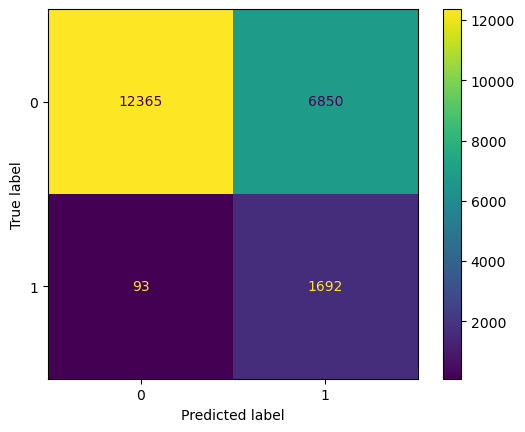

(0.7990783198525311,
 0.7957034179792135,
 0.5790397777086045,
 0.5781992335986269,
 0.9527010804321728,
 0.9478991596638655,
 0.5432044682948198,
 0.5394720061216681,
 0.6715714285714286,
 0.6693809523809524,
 0.6454555592728894,
 0.6435076762945615)

In [74]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
priors = class_weights / class_weights.sum()  # Normalizujemy, aby suma wynosiła 1
bayes = GaussianNB(priors=priors)
scores_model(X_train_transformed_df, X_test_transformed_df, bayes)


Model Performance:
Training Recall Score: 0.8439
Test Recall Score: 0.8510
Training F2 Score: 0.6608
Test F2 Score: 0.6638
Training Specificity Score: 0.8568
Test Specificity Score: 0.8552
Training ROC-AUC: 0.8504
Test ROC-AUC: 0.8531
Training PR-AUC: 0.5791
Test PR-AUC: 0.5782
Training Accuracy Score: 0.8557
Test Accuracy Score: 0.8549
Test Confusion Matrix:
 [[16433  2782]
 [  266  1519]]


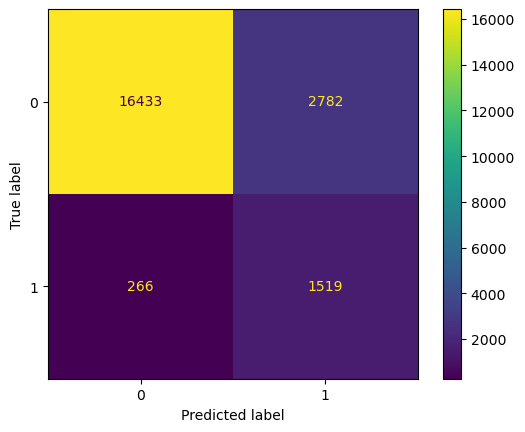

(0.8503617840578854,
 0.8530988351624802,
 0.5791326399852448,
 0.5781518468406931,
 0.843937575030012,
 0.8509803921568627,
 0.6608136561889005,
 0.6638405733764531,
 0.8556938775510204,
 0.8548571428571429,
 0.8567859930857589,
 0.8552172781680979)

In [75]:
bayes = GaussianNB()

param_grid = {
    'var_smoothing': np.logspace(-9, 0, 20) 
}

grid_search = GridSearchCV(bayes, param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train_transformed_df, y_train)

bayes_best = grid_search.best_estimator_
scores_model(X_train_transformed_df, X_test_transformed_df, bayes_best)

**SVC**


Model Performance:
Training Recall Score: 0.8934
Test Recall Score: 0.9042
Training F2 Score: 0.7312
Test F2 Score: 0.7377
Training Specificity Score: 0.8870
Test Specificity Score: 0.8862
Training ROC-AUC: 0.8902
Test ROC-AUC: 0.8952
Training PR-AUC: 0.8186
Test PR-AUC: 0.8236
Training Accuracy Score: 0.8876
Test Accuracy Score: 0.8878
Test Confusion Matrix:
 [[17029  2186]
 [  171  1614]]


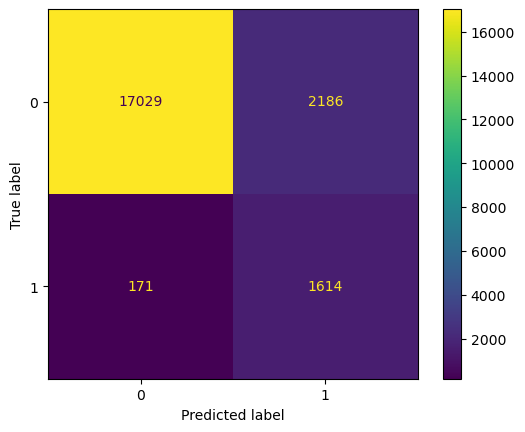

(0.8902137904342065,
 0.8952181965682448,
 0.8186356266208694,
 0.8236332999770399,
 0.8933973589435774,
 0.9042016806722689,
 0.7311561738583667,
 0.7376599634369287,
 0.8875714285714286,
 0.8877619047619048,
 0.8870302219248355,
 0.8862347124642207)

In [76]:
svc = SVC(kernel='linear', C=0.5, probability=True, class_weight='balanced', random_state=32)  
scores_model(X_train_transformed_df, X_test_transformed_df, svc)

**Stacking**

In [77]:
# przygotowanie stacking
def get_stacking():
    
    # define the base models
    level0 = list()
    level0.append(('lr', lr_best))
    level0.append(('cart', dtc_best))
    level0.append(('rf', rf_best))
    level0.append(('bagging', bagging_best))
    level0.append(('gboost', gboost_best))
    level0.append(('xgb', xgb_best))
    #level0.append(('svm', svc))
    level0.append(('bayes', bayes_best))
    
    # definicja meta learner model
    level1 = lr_best
    
    # definicja stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    
    return model

In [78]:
# lista modeli
def get_models():
    
    models = dict()
    models['lr'] = lr_best
    models['cart'] =dtc_best
    models['rf'] = rf_best
    models['gboost'] = gboost_best
    models['xgb'] = xgb_best
    #models['svm'] = svc
    models['bayes'] = bayes_best
    models['bagging'] = bagging_best
    models['stacking'] = get_stacking()

    return models

In [79]:
# ocena modeli przy wykorzystaniu cross-validation
def evaluate_model(model, X, y):
    # Cross-validation setup with Repeated Stratified KFold
    cv = RepeatedStratifiedKFold(n_splits=6, n_repeats=1, random_state=32)
    
    # Recall and F2 scores using cross_val_score
    recall_scores = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1, error_score='raise')
    f2_scores = cross_val_score(model, X, y, scoring=f2_scorer, cv=cv, n_jobs=-1, error_score='raise')
    
    return recall_scores, f2_scores

In [80]:
# modele do evaluacji
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

f2_scorer = make_scorer(fbeta_score, beta=2)

# Get models function (assumed to be defined elsewhere)
models = get_models()

# Results container
results_recall, results_f2, names = list(), list(), list()
results_recall_test, results_f2_test= list(), list()


# Evaluate models
for name, model in models.items():
    recall_scores, f2_scores = evaluate_model(model, X_train_transformed_df, y_train)
    recall_scores_test, f2_scores_test = evaluate_model(model, X_test_transformed_df, y_test)

    
    # Store the results
    results_recall.append(recall_scores)
    results_f2.append(f2_scores)
    names.append(name)
    results_recall_test.append(recall_scores_test)
    results_f2_test.append(f2_scores_test)
    
    # Print results for both Recall and F2 score (mean and std)
    print(f"{name:8} Recall mean: {np.mean(recall_scores):.3f} std: {np.std(recall_scores):.3f}")
    print(f"{name:8} F2 mean: {np.mean(f2_scores):.3f} std: {np.std(f2_scores):.3f}")
    print(f"{name:8} Recall mean test: {np.mean(recall_scores_test):.3f} std: {np.std(recall_scores_test):.3f}")
    print(f"{name:8} F2 mean test: {np.mean(f2_scores_test):.3f} std: {np.std(f2_scores_test):.3f}")

lr       Recall mean: 0.889 std: 0.011
lr       F2 mean: 0.728 std: 0.010
lr       Recall mean test: 0.895 std: 0.018
lr       F2 mean test: 0.734 std: 0.014
cart     Recall mean: 0.981 std: 0.003
cart     F2 mean: 0.604 std: 0.004
cart     Recall mean test: 0.979 std: 0.008
cart     F2 mean test: 0.606 std: 0.007
rf       Recall mean: 0.922 std: 0.010
rf       F2 mean: 0.746 std: 0.008
rf       Recall mean test: 0.900 std: 0.025
rf       F2 mean test: 0.763 std: 0.015
gboost   Recall mean: 0.919 std: 0.015
gboost   F2 mean: 0.758 std: 0.009
gboost   Recall mean test: 0.908 std: 0.023
gboost   F2 mean test: 0.768 std: 0.013
xgb      Recall mean: 0.918 std: 0.008
xgb      F2 mean: 0.654 std: 0.006
xgb      Recall mean test: 0.922 std: 0.011
xgb      F2 mean test: 0.657 std: 0.011
bayes    Recall mean: 0.843 std: 0.013
bayes    F2 mean: 0.659 std: 0.011
bayes    Recall mean test: 0.838 std: 0.023
bayes    F2 mean test: 0.663 std: 0.020
bagging  Recall mean: 0.913 std: 0.009
bagging  F2 m

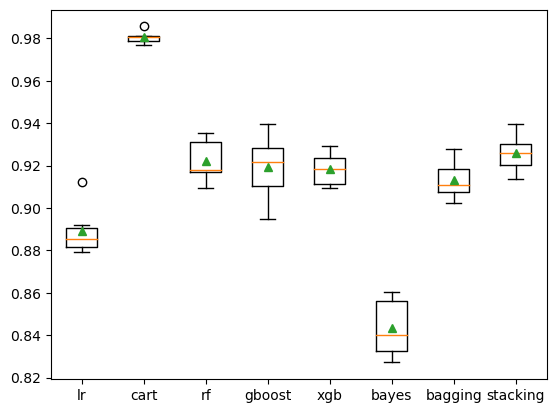

In [82]:
plt.boxplot(results_recall, labels=names, showmeans=True)
plt.show()

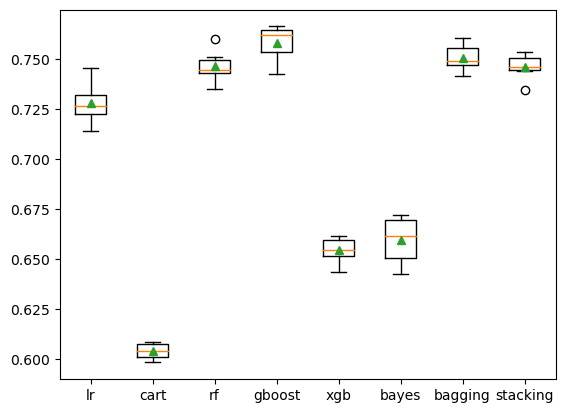

In [83]:
plt.boxplot(results_f2, labels=names, showmeans=True)
plt.show()

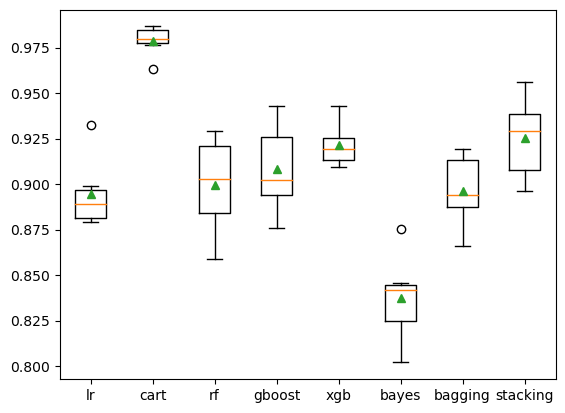

In [84]:
plt.boxplot(results_recall_test, labels=names, showmeans=True)
plt.show()

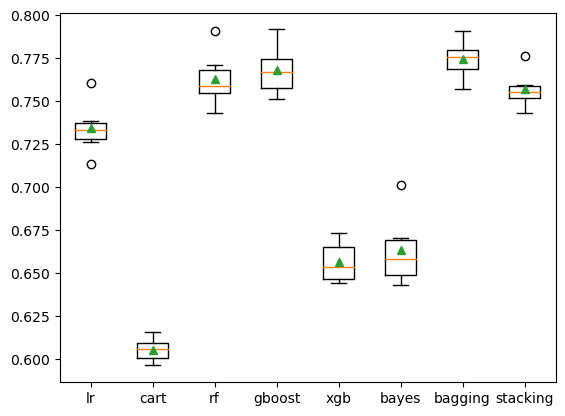

In [85]:
plt.boxplot(results_f2_test, labels=names, showmeans=True)
plt.show()